In [1]:
from __future__ import print_function

In [2]:
import torch

import cv2

import torch.optim as optim
import torch.nn as nn

import sys

import torchvision.transforms as transforms
from torch.autograd import Variable
import random

from torchvision import models
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
!jupyter nbconvert --to python models/MultiFrameCNN.ipynb
from models import MultiFrameCNN
reload(MultiFrameCNN)

[NbConvertApp] Converting notebook models/MultiFrameCNN.ipynb to python
[NbConvertApp] Writing 8051 bytes to models/MultiFrameCNN.py


<module 'models.MultiFrameCNN' from 'models/MultiFrameCNN.pyc'>

In [4]:
!jupyter nbconvert --to python dataset/VideoSequenceDataset.ipynb
from dataset import VideoSequenceDataset
reload(VideoSequenceDataset)

[NbConvertApp] Converting notebook dataset/VideoSequenceDataset.ipynb to python
[NbConvertApp] Writing 8829 bytes to dataset/VideoSequenceDataset.py
[NbConvertApp] WARNING | pattern u'Dataset.ipynb' matched no files
This application is used to convert notebook files (*.ipynb) to various other
formats.


Options
-------

Arguments that take values are actually convenience aliases to full
Configurables, whose aliases are listed on the help line. For more information
on full configurables, see '--help-all'.

--execute
    Execute the notebook prior to export.
--allow-errors
    Continue notebook execution even if one of the cells throws an error and include the error message in the cell output (the default behaviour is to abort conversion). This flag is only relevant if '--execute' was specified, too.
--stdout
    Write notebook output to stdout instead of files.
--stdin
    read a single notebook file from stdin. Write the resulting notebook with default basename 'notebook.*'
--inplace
 

<module 'dataset.VideoSequenceDataset' from 'dataset/VideoSequenceDataset.pyc'>

In [5]:
!jupyter nbconvert --to python models/SuperMobile.ipynb
from models import SuperMobile
reload(SuperMobile)

[NbConvertApp] Converting notebook models/SuperMobile.ipynb to python
[NbConvertApp] Writing 13373 bytes to models/SuperMobile.py


<module 'models.SuperMobile' from 'models/SuperMobile.pyc'>

In [24]:
!jupyter nbconvert --to python models/ShuffleNet.ipynb
from models import ShuffleNet
reload(ShuffleNet)

[NbConvertApp] Converting notebook models/ShuffleNet.ipynb to python
[NbConvertApp] Writing 10126 bytes to models/ShuffleNet.py


<module 'models.ShuffleNet' from 'models/ShuffleNet.py'>

In [7]:
def test(model, testDataset, cuda=True):
    model = model.eval()
    tot = 0
    cor = 0
    for i, (batch, labels) in enumerate(testDataset):
        if cuda:
            batch = batch.cuda()
            labels = labels.cuda()
        outputs=model(Variable(batch))
        _, pred = torch.max(outputs.data, 1)
        tot += labels.size(0)
        cor += (pred == labels).sum()
        
    print(cor, "/", tot, " : ", cor*1.0/tot*100, "%")
    

In [8]:
def train(model, optimizer, trainDataset, valDataset, trans, nbepoch=5, cuda=True):
    #criterion = nn.CrossEntropyLoss(Variable(torch.Tensor([1/5.2,1/5.2,1/5.2,1/5.2,1/5.2,0.2/5.2])))
    criterion = nn.CrossEntropyLoss()
    if cuda:
        model = model.cuda()
    for epoch in range(nbepoch):
        print("Epoch ", epoch, "precision : ")
        test(model, valDataset, cuda)
        
        model = model.train()
        lo = 0
        for i, (batch,labels) in enumerate(trainDataset):
            if cuda:
                batch = batch.cuda()
                labels = labels.cuda()
            
            outputs = model(Variable(batch))
            #label = torch.LongTensor([gesture])
            loss = criterion(outputs, Variable(labels))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            lo += loss.data[0]
            if i%10 == 0:
                print(i,' : ', lo/10.0)
                lo = 0

In [10]:
#model = MultiFrameCNN.MultiFrameResNet(MultiFrameCNN.BasicBlock, [2,2,2,2], sequence=1, num_classes=27, groups=1)
#with 3 frame, and 3 groups and skip 1: accuracy 100%
#model = MultiFrameCNN.DummyMultiFrame()
#model = MultiFrameCNN.MultiFrameCNN(nbClasse=6,nbFrame=3)
#model = MultiFrameCNN.MultiFrameCNN(3) -> 58,333%
#model.copyParameters(models.alexnet(pretrained=True))
#model = models.AlexNet(num_classes=6)
#model = model.cuda()
#model=SuperMobile.SuperMobile()
#model=SuperMobile.DenseMobile(in_channel=3, num_classes=27, nb_frames=3)
#model=SuperMobile.DenseMobile(nb_frames=3)
model = ShuffleNet.ShuffleNet(num_classes=6)

models/ShuffleNet.py:255: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight, mode='fan_out')
models/ShuffleNet.py:257: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias, 0)
models/ShuffleNet.py:259: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.weight, 1)
models/ShuffleNet.py:260: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias, 0)
models/ShuffleNet.py:262: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight, std=0.001)
models/ShuffleNet.py:264: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias, 0)


In [34]:
import torch
import torch.optim as optim
import torch.nn as nn
from collections import OrderedDict
from torch.nn import init
import torch.nn.functional as F

def conv3x3(in_channels, out_channels, stride=1, 
            padding=1, bias=True, groups=1):    
    """3x3 convolution with padding
    """
    return nn.Conv2d(
        in_channels, 
        out_channels, 
        kernel_size=3, 
        stride=stride,
        padding=padding,
        bias=bias,
        groups=groups)


def conv1x1(in_channels, out_channels, groups=1):
    """1x1 convolution with padding
    - Normal pointwise convolution When groups == 1
    - Grouped pointwise convolution when groups > 1
    """
    return nn.Conv2d(
        in_channels, 
        out_channels, 
        kernel_size=1, 
        groups=groups,
        stride=1)

class ShuffleUnit(nn.Module):
    def __init__(self, in_channels, out_channels, groups=3,
                 grouped_conv=True, combine='add'):
        
        super(ShuffleUnit, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.grouped_conv = grouped_conv
        self.combine = combine
        self.groups = groups
        self.bottleneck_channels = self.out_channels // 4

        # define the type of ShuffleUnit
        if self.combine == 'add':
            # ShuffleUnit Figure 2b
            self.depthwise_stride = 1
            self._combine_func = self._add
        elif self.combine == 'concat':
            # ShuffleUnit Figure 2c
            self.depthwise_stride = 2
            self._combine_func = self._concat
            
            # ensure output of concat has the same channels as 
            # original output channels.
            self.out_channels -= self.in_channels
        else:
            raise ValueError("Cannot combine tensors with \"{}\"" \
                             "Only \"add\" and \"concat\" are" \
                             "supported".format(self.combine))

        # Use a 1x1 grouped or non-grouped convolution to reduce input channels
        # to bottleneck channels, as in a ResNet bottleneck module.
        # NOTE: Do not use group convolution for the first conv1x1 in Stage 2.
        self.first_1x1_groups = self.groups if grouped_conv else 1

        self.g_conv_1x1_compress = self._make_grouped_conv1x1(
            self.in_channels,
            self.bottleneck_channels,
            self.first_1x1_groups,
            batch_norm=True,
            relu=True
            )

        # 3x3 depthwise convolution followed by batch normalization
        self.depthwise_conv3x3 = conv3x3(
            self.bottleneck_channels, self.bottleneck_channels,
            stride=self.depthwise_stride, groups=self.bottleneck_channels)
        self.bn_after_depthwise = nn.BatchNorm2d(self.bottleneck_channels)

        # Use 1x1 grouped convolution to expand from 
        # bottleneck_channels to out_channels
        self.g_conv_1x1_expand = self._make_grouped_conv1x1(
            self.bottleneck_channels,
            self.out_channels,
            self.groups,
            batch_norm=True,
            relu=False
            )


    @staticmethod
    def _add(x, out):
        # residual connection
        return x + out

    
    def _channel_shuffle(self, x, groups):
        batchsize, num_channels, height, width = x.data.size()

        channels_per_group = num_channels // groups
        x = x.view(batchsize, groups, channels_per_group, height, width) #add a new dimension

        x = torch.transpose(x, 1, 2).contiguous()
        return x.view(batchsize, -1, height, width)

    @staticmethod
    def _concat(x, out):
        # concatenate along channel axis
        return torch.cat((x, out), 1)


    def _make_grouped_conv1x1(self, in_channels, out_channels, groups,
        batch_norm=True, relu=False):

        modules = OrderedDict()

        conv = conv1x1(in_channels, out_channels, groups=groups)
        modules['conv1x1'] = conv

        if batch_norm:
            modules['batch_norm'] = nn.BatchNorm2d(out_channels)
        if relu:
            modules['relu'] = nn.ReLU()
        if len(modules) > 1:
            return nn.Sequential(modules)
        else:
            return conv


    def forward(self, x):
        # save for combining later with output
        residual = x

        if self.combine == 'concat':
            residual = F.avg_pool2d(residual, kernel_size=3, 
                stride=2, padding=1)

        out = self.g_conv_1x1_compress(x)
        out = self._channel_shuffle(out, self.groups)
        out = self.depthwise_conv3x3(out)
        out = self.bn_after_depthwise(out)
        out = self.g_conv_1x1_expand(out)
        
        out = self._combine_func(residual, out)
        return F.relu(out)


class ShuffleNet(nn.Module):
    """ShuffleNet implementation.
    """

    def __init__(self, groups=3, in_channels=3, num_classes=1000):
        """ShuffleNet constructor.
        Arguments:
            groups (int, optional): number of groups to be used in grouped 
                1x1 convolutions in each ShuffleUnit. Default is 3 for best
                performance according to original paper.
            in_channels (int, optional): number of channels in the input tensor.
                Default is 3 for RGB image inputs.
            num_classes (int, optional): number of classes to predict. Default
                is 1000 for ImageNet.
        """
        super(ShuffleNet, self).__init__()

        self.groups = groups
        self.stage_repeats = [3, 7, 3]
        self.in_channels =  in_channels
        self.num_classes = num_classes

        # index 0 is invalid and should never be called.
        # only used for indexing convenience.
        if groups == 1:
            self.stage_out_channels = [-1, 24, 144, 288, 567]
        elif groups == 2:
            self.stage_out_channels = [-1, 24, 200, 400, 800]
        elif groups == 3:
            self.stage_out_channels = [-1, 24, 240, 480, 960]
        elif groups == 4:
            self.stage_out_channels = [-1, 24, 272, 544, 1088]
        elif groups == 8:
            self.stage_out_channels = [-1, 24, 384, 768, 1536]
        else:
            raise ValueError(
                """{} groups is not supported for
                   1x1 Grouped Convolutions""".format(num_groups))
        
        # Stage 1 always has 24 output channels
        self.conv1 = conv3x3(self.in_channels,
                             self.stage_out_channels[1], # stage 1
                             stride=2)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Stage 2
        self.stage2 = self._make_stage(2)
        # Stage 3
        self.stage3 = self._make_stage(3)
        # Stage 4
        self.stage4 = self._make_stage(4)

        # Global pooling:
        # Undefined as PyTorch's functional API can be used for on-the-fly
        # shape inference if input size is not ImageNet's 224x224

        # Fully-connected classification layer
        num_inputs = self.stage_out_channels[-1]
        self.fc = nn.Linear(num_inputs, self.num_classes)
        self.init_params()


    def init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal(m.weight, mode='fan_out')
                if m.bias is not None:
                    init.constant(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant(m.weight, 1)
                init.constant(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal(m.weight, std=0.001)
                if m.bias is not None:
                    init.constant(m.bias, 0)


    def _make_stage(self, stage):
        modules = OrderedDict()
        stage_name = "ShuffleUnit_Stage{}".format(stage)
        
        # First ShuffleUnit in the stage
        # 1. non-grouped 1x1 convolution (i.e. pointwise convolution)
        #   is used in Stage 2. Group convolutions used everywhere else.
        grouped_conv = stage > 2
        
        # 2. concatenation unit is always used.
        first_module = ShuffleUnit(
            self.stage_out_channels[stage-1],
            self.stage_out_channels[stage],
            groups=self.groups,
            grouped_conv=grouped_conv,
            combine='concat'
            )
        modules[stage_name+"_0"] = first_module

        # add more ShuffleUnits depending on pre-defined number of repeats
        for i in range(self.stage_repeats[stage-2]):
            name = stage_name + "_{}".format(i+1)
            module = ShuffleUnit(
                self.stage_out_channels[stage],
                self.stage_out_channels[stage],
                groups=self.groups,
                grouped_conv=True,
                combine='add'
                )
            modules[name] = module

        return nn.Sequential(modules)


    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)

        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)

        # global average pooling layer
        x = F.avg_pool2d(x, x.data.size()[-2:])
        
        # flatten for input to fully-connected layer
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return F.log_softmax(x, dim=1)

In [11]:
def nbParameters(net):
    p = 0
    for m in net.parameters():
        p += m.data.nelement()
    return p

In [12]:
if __name__ == '__main__':
    #model=SuperMobile.DenseMobile(first_group=True)
    print(nbParameters(model))

922686


In [13]:
trans = transforms.Compose(
                (
                    transforms.ToPILImage(),
                    transforms.Resize(224),
                transforms.RandomCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406,0.485, 0.456, 0.406,0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225,0.229, 0.224, 0.225,0.229, 0.224, 0.225]),
                )
                )

trainDataset = VideoSequenceDataset.VideoDataset(rep="/video/GestureSequence/", SequenceSize=1, batchSize=32, transform=trans, 
                concat=True, dropFrame=1)

#trainDataset, testDataset, labels = VideoSequenceDataset.twentybnDataset(nbFrames=3, batch=32, validationFile="/video/twentybn/jester-v1-validationSmall.csv", 
#                                                                         trainFile="/video/twentybn/jester-v1-trainSmall.csv", dropFrame=1)


#TODO create validation and test datasets !
testDataset = VideoSequenceDataset.VideoDataset(rep="/video/GestureTest/", SequenceSize=1, batchSize=16, transform=trans, 
            concat=True, dropFrame=1)

In [18]:
optimizer = optim.SGD( model.parameters(),lr=0.0001, momentum=0.9, weight_decay=0.0005)

In [19]:
train(model,optimizer,trainDataset,testDataset,trans, nbepoch=30, cuda=True)

Epoch  0 precision : 
tensor(15, device='cuda:0') / 16  :  tensor(0, device='cuda:0') %


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


0  :  tensor(1.00000e-02 *
       2.7120, device='cuda:0')
10  :  tensor(0.2082, device='cuda:0')
20  :  tensor(0.1726, device='cuda:0')
Epoch  1 precision : 
tensor(14, device='cuda:0') / 16  :  tensor(0, device='cuda:0') %
0  :  tensor(1.00000e-02 *
       4.6148, device='cuda:0')
10  :  tensor(0.2543, device='cuda:0')
20  :  tensor(0.1499, device='cuda:0')
Epoch  2 precision : 
tensor(11, device='cuda:0') / 16  :  tensor(0, device='cuda:0') %
0  :  tensor(1.00000e-02 *
       1.6417, device='cuda:0')
10  :  tensor(0.2132, device='cuda:0')
20  :  tensor(0.2043, device='cuda:0')
Epoch  3 precision : 
tensor(12, device='cuda:0') / 16  :  tensor(0, device='cuda:0') %
0  :  tensor(1.00000e-02 *
       1.7114, device='cuda:0')
10  :  tensor(0.1950, device='cuda:0')
20  :  tensor(0.1834, device='cuda:0')
Epoch  4 precision : 
tensor(12, device='cuda:0') / 16  :  tensor(0, device='cuda:0') %
0  :  tensor(1.00000e-02 *
       1.7662, device='cuda:0')
10  :  tensor(0.1876, device='cuda:0')
20

In [150]:
for a in trainDataset:
    i = a
    break

RuntimeError: Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/torch/utils/data/dataloader.py", line 55, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "dataset/Dataset.py", line 94, in __getitem__
    return self.fileOperation(os.path.join(self.baseDir, e)), self.targetOperation(c)
  File "dataset/VideoSequenceDataset.py", line 223, in <lambda>
    fileOperation    = lambda x:__readNImages(x, nbFrames, transform, drop=dropFrame)
  File "dataset/VideoSequenceDataset.py", line 161, in __readNImages
    t[imSaved] = transform(img)
RuntimeError: inconsistent tensor size, expected tensor [3 x 128 x 128] and src [3 x 224 x 224] to have the same number of elements, but got 49152 and 150528 elements respectively at /pytorch/torch/lib/TH/generic/THTensorCopy.c:86


In [20]:
model = model.cpu()

In [25]:
model

ShuffleNet(
  (conv1): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (ShuffleUnit_Stage2_0): ShuffleUnit(
      (g_conv_1x1_compress): Sequential(
        (conv1x1): Conv2d(24, 60, kernel_size=(1, 1), stride=(1, 1))
        (batch_norm): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
      (depthwise_conv3x3): Conv2d(60, 60, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=60)
      (bn_after_depthwise): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (g_conv_1x1_expand): Sequential(
        (conv1x1): Conv2d(60, 216, kernel_size=(1, 1), stride=(1, 1), groups=3)
        (batch_norm): BatchNorm2d(216, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (ShuffleUnit_Stage2_1): ShuffleUnit(
      (g_conv_1x1_compress)

In [26]:
help(torch.save)

Help on function save in module torch.serialization:

save(obj, f, pickle_module=<module 'cPickle' (built-in)>, pickle_protocol=2)
    Saves an object to a disk file.
    
    See also: :ref:`recommend-saving-models`
    
    Args:
        obj: saved object
        f: a file-like object (has to implement write and flush) or a string
           containing a file name
        pickle_module: module used for pickling metadata and objects
        pickle_protocol: can be specified to override the default protocol
    
    .. warning::
        If you are using Python 2, torch.save does NOT support StringIO.StringIO
        as a valid file-like object. This is because the write method should return
        the number of bytes written; StringIO.write() does not do this.
    
        Please use something like io.BytesIO instead.
    
    Example:
        >>> # Save to file
        >>> x = torch.tensor([0, 1, 2, 3, 4])
        >>> torch.save(x, 'tensor.pt')
        >>> # Save to io.BytesIO buffer

In [27]:
torch.save(model, "gesture_best_1.pytorch")

PicklingError: Can't pickle <class 'models.ShuffleNet.ShuffleNet'>: it's not the same object as models.ShuffleNet.ShuffleNet

In [30]:
statedict = model.state_dict()

In [31]:
statedictSaved = statedict.copy()

In [35]:
model2 = ShuffleNet(num_classes=6)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:214: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:216: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:217: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:219: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:221: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.


In [36]:
model2.load_state_dict(statedictSaved)

In [38]:
import cPickle

In [40]:
with open('statedictShuffle.sd', 'wb') as f:
    cPickle.dump(statedictSaved, f)

In [37]:
torch.save(model2, 'test2')

/usr/local/lib/python2.7/dist-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type ShuffleNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python2.7/dist-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type ShuffleUnit. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


PicklingError: Can't pickle <type 'function'>: attribute lookup __builtin__.function failed

In [68]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

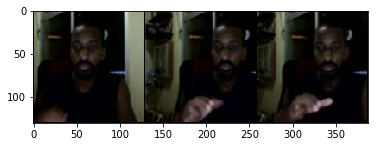

In [16]:
show(make_grid([a[0][4][:3], a[0][4][3:6], a[0][4][6:9]], padding=1, normalize=False))